In [1]:
import numpy as np
import pandas as pd
from plot_tree import *

In [2]:
data = pd.read_table("./play.txt", sep=",")
# data['id'] = np.arange(1,15)
data

,outlook,temperature,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,rainy,mild,normal,False,yes
8,sunny,mild,normal,True,yes
9,overcast,mild,high,True,yes


### DT

In [3]:
## 计算给定属性的信息熵
def cal_entropy(data, feature, label):
    en = []
    ratio = []
    for _, groups in data.groupby(feature):
        ratio.append(len(groups) / len(data))
        values = groups[label].value_counts(normalize=True).values
        log_values = np.log2(values)
        entropy = -1.0 * sum(values * log_values)
        en.append(entropy)
    res = sum(np.array(en) * np.array(ratio))
    return res

## 计算标签的信息熵
def cal_entropy_all(data, label):
    values = data[label].value_counts(normalize=True).values
    log_values = np.log2(values) 
    overall_entropy = -1.0 * sum(values * log_values)
    return overall_entropy

## 计算信息增益
def cal_entropy_gain(overall_entropy, feature_entropy):
    return overall_entropy - feature_entropy

## 获取标签最多的那一类
def get_most_label(data, label):
    label_sort = data[label].value_counts(sort=True)
    return label_sort.keys()[0]


## 挑选最优特征，即信息增益最大的特征
def get_best_feature(data, label):
    overall_entropy = cal_entropy_all(data=data, label=label)
    features = data.drop(label, axis=1).columns
    gain = {}
    for f in features:
        feature_entropy = cal_entropy(data, feature=f, label=label)
        entropy_gain = cal_entropy_gain(overall_entropy, feature_entropy)
        gain[f] = entropy_gain
    gain_sorted_values = sorted(gain.items(), key=lambda x:x[1], reverse=True)
    return gain_sorted_values[0][0]


## 将数据转化为（属性值：数据）的元组形式返回，并删除之前的特征列
def drop_exist_feature(data, best_feature):
    attr = pd.unique(data[best_feature])
    new_data = [(nd, data[data[best_feature] == nd]) for nd in attr]
    new_data = [(n[0], n[1].drop([best_feature], axis=1)) for n in new_data]
    return new_data


## 得到除了label以外每个属性的取值
def get_labels_full(data, label):
    labels_full = dict([(nf, list(data[nf].value_counts().keys())) for nf in data.drop(label, axis=1).columns])
    return labels_full

In [131]:
# ## 获取标签最多的那一类
# get_most_label(data, label = 'play')

# ## 挑选最优特征，即信息增益最大的特征
# get_best_feature(data = data, label = 'play')

# ## 将数据转化为（属性值：数据）的元组形式返回，并删除之前的特征列
# drop_exist_feature(data, best_feature = get_best_feature(data = data, label = 'play'))

In [4]:
def create_tree(data, label):
    data_label = data[label]
    if len(data_label.value_counts()) == 1: #标签只有一类，停止分裂
        return data_label.values[0]
    
    if data.shape[1] == 1:     #每条数据只剩下了标签，停止分裂
        return get_most_label(data, label = label)
    
    best_feature = get_best_feature(data=data, label=label)   #根据信息增益得到的最优划分特征
    Tree = {best_feature:{}}
    
    for item in drop_exist_feature(data, best_feature = best_feature):
        Tree[best_feature][item[0]] = create_tree(item[1], label=label) 
    return Tree


def predict(Tree, test_data):
    first_feature = list(Tree.keys())[0]
    second_dict = Tree[first_feature]
    input_first = test_data.get(first_feature)
    input_value = second_dict[input_first]
    if isinstance(input_value , dict): #判断分支还是不是字典
        class_label = predict(input_value, test_data)
    else:
        class_label = input_value
    return class_label

#### 数据集一

In [5]:
data = pd.read_table("./play.txt", sep=",")

clf_mytree = create_tree(data, label='play')
clf_mytree

{'outlook': {'sunny': {'humidity': {'high': 'no', 'normal': 'yes'}},
  'overcast': 'yes',
  'rainy': {'windy': {False: 'yes', True: 'no'}}}}

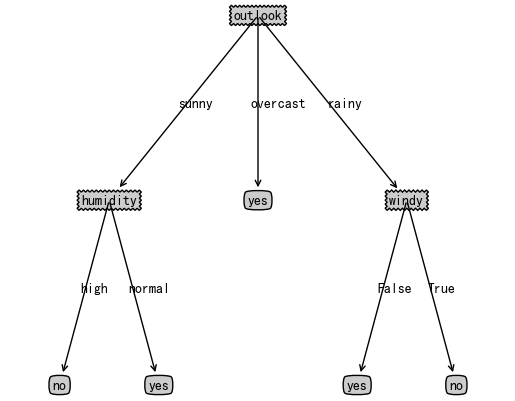

In [6]:
labels_full = get_labels_full(data, label='play')
makeTreeFull(clf_mytree,labels_full,default='未知')
createPlot(clf_mytree)   

In [7]:
test_data_1 = {'outlook':'overcast', 
               'temperature': 'mild',
               'humidity':'high', 
               'windy':'True'}
test_data_2 = {'outlook':'sunny', 
               'temperature': 'hot',
               'humidity':'high', 
               'windy':'False'}
test_data_3 = {'outlook':'sunny', 
               'temperature': 'cool',
               'humidity':'normal', 
               'windy':'True'}

print(predict(clf_mytree, test_data_1))
print(predict(clf_mytree, test_data_2))
print(predict(clf_mytree, test_data_3))

yes
no
yes


#### 数据集二

In [8]:
data_gua = pd.read_table("./watermelon.txt", sep=",").drop("编号",axis=1)
data_gua['好瓜'] = data_gua['好瓜'].apply(lambda x:'好瓜' if x == "是" else "坏瓜")
data_gua 

,色泽,根蒂,敲声,纹理,脐部,触感,好瓜
0,青绿,蜷缩,浊响,清晰,凹陷,硬滑,好瓜
1,乌黑,蜷缩,沉闷,清晰,凹陷,硬滑,好瓜
2,乌黑,蜷缩,浊响,清晰,凹陷,硬滑,好瓜
3,青绿,蜷缩,沉闷,清晰,凹陷,硬滑,好瓜
4,浅白,蜷缩,浊响,清晰,凹陷,硬滑,好瓜
5,青绿,稍蜷,浊响,清晰,稍凹,软粘,好瓜
6,乌黑,稍蜷,浊响,稍糊,稍凹,软粘,好瓜
7,乌黑,稍蜷,浊响,清晰,稍凹,硬滑,好瓜
8,乌黑,稍蜷,沉闷,稍糊,稍凹,硬滑,坏瓜
9,青绿,硬挺,清脆,清晰,平坦,软粘,坏瓜


In [9]:
clf_mytree_fu = create_tree(data_gua, label='好瓜')
clf_mytree_fu

{'纹理': {'清晰': {'根蒂': {'蜷缩': '好瓜',
    '稍蜷': {'色泽': {'青绿': '好瓜', '乌黑': {'触感': {'硬滑': '好瓜', '软粘': '坏瓜'}}}},
    '硬挺': '坏瓜'}},
  '稍糊': {'触感': {'软粘': '好瓜', '硬滑': '坏瓜'}},
  '模糊': '坏瓜'}}

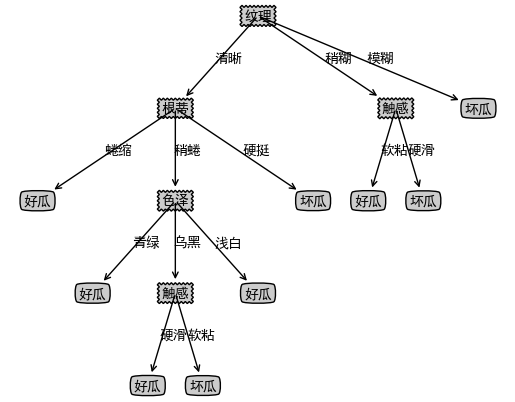

In [10]:
labels_full = get_labels_full(data_gua, label='好瓜')
makeTreeFull(clf_mytree_fu,labels_full,default='未知')
createPlot(clf_mytree_fu)

### sklearn决策树

In [101]:
data = pd.read_table("./play.txt", sep=",")
data

,outlook,temperature,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,rainy,mild,normal,False,yes
8,sunny,mild,normal,True,yes
9,overcast,mild,high,True,yes


In [102]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
data['outlook'] = lb.fit_transform(data['outlook'])
data['temperature'] = lb.fit_transform(data['temperature'])
data['humidity'] = lb.fit_transform(data['humidity'])
data['windy'] = lb.fit_transform(data['windy'])
data['play'] = lb.fit_transform(data['play'])

data

,outlook,temperature,humidity,windy,play
0,2,1,0,0,0
1,2,1,0,1,0
2,0,1,0,0,1
3,1,2,0,0,1
4,1,0,1,0,1
5,1,0,1,1,0
6,0,0,1,1,1
7,1,2,1,0,1
8,2,2,1,1,1
9,0,2,0,1,1


In [103]:
from sklearn import tree
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=30, splitter="random")
clf = clf.fit(X, y) 
clf.score(X, y)

1.0

In [104]:
[*zip(X.columns, clf.feature_importances_)]  # 特征重要度

[('outlook', 0.3626285821279446),
 ('temperature', 0.15192946522259376),
 ('humidity', 0.21123657918595443),
 ('windy', 0.2742053734635072)]

In [105]:
test_data = pd.DataFrame({'outlook':['overcast','sunny','sunny'],   # yes, no, yes
              "temperature":['mild','hot','cool'],
              "humidity":['high','high','normal'],
              "windy":['True','False','True']})
test_data

,outlook,temperature,humidity,windy
0,overcast,mild,high,True
1,sunny,hot,high,False
2,sunny,cool,normal,True


In [106]:
test_data['outlook'] = lb.fit_transform(test_data['outlook'])
test_data['temperature'] = lb.fit_transform(test_data['temperature'])
test_data['humidity'] = lb.fit_transform(test_data['humidity'])
test_data['windy'] = lb.fit_transform(test_data['windy'])
test_data

,outlook,temperature,humidity,windy
0,0,2,0,1
1,1,1,0,0
2,1,0,1,1


In [107]:
clf.predict(test_data)

array([1, 1, 0])